In [ ]:
#!pip install opencv-python pixellib

In [4]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.12.0


# 인물 사진

### shallow focus 함수 정의

In [15]:
# 함수 정의
def shallow_focus(img_orig):
    """
    사람 이미지를 입력받아 인물사진 효과를 적용해 출력하는 함수
    model: deeplabv3_resnet101
    """
    # --- 1. 모델 다운로드 및 전처리 ---
    model = deeplabv3_resnet101(pretrained=True).eval()

    # 사전 학습된 모델을 사용하기 때문에
    # 모델의 전처리 방식과 입력 크기 등이 사전 학습에 사용된 것과 동일해야 한다.
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),  # 모델 입력 크기 (고정)
        T.ToTensor(),
    ])
    input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

    # 모델에 이미지 입력
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    # 원본 크기로 Resize
    output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)


    # --- 2. 세그먼트 맵, 마스크 정의 ---
    seg_map = (output_predictions_resized == 15)  # 사람 id
    img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)


    # --- 3. 배경 흐리게 처리 ---
    img_orig_blur = cv2.blur(img_orig, (20, 20))


    # --- 4. 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출 ---
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 이미지를 반전시켜 배경은 255(흰색) 사람은 0(검정)으로 만든다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 되어 사람이 사라지고 배경만 남는다.
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)


    # --- 5. 흐린 배경과 원본 영상 합성 ---
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)


    # --- 6. 최종 이미지 출력 ---
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img_concat)
    plt.title("Shallow Focus Image")

    plt.show()

### 예시 1

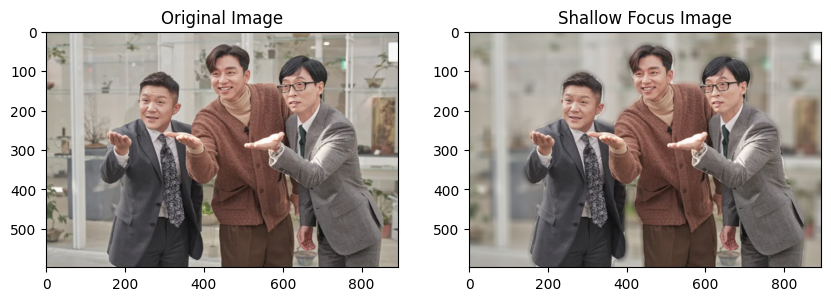

In [16]:
youquiz = cv2.imread("/content/youquiz.png")

shallow_focus(youquiz)

### 예시 2

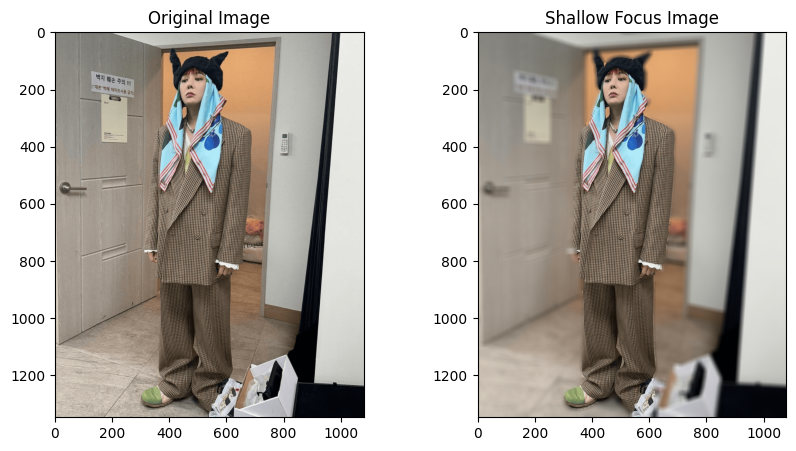

In [17]:
gd = cv2.imread("/content/gd.png")

shallow_focus(gd)

# 배경 전환 크로마키

In [51]:
def Chroma_Key(main_img, background_img):
    """
    메인 이미지와 배경 이미지를 받아 합성하는 함수
    model: deeplabv3_resnet101
    """
    main_img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)

    # --- 1. 모델 다운로드 및 전처리
    model = deeplabv3_resnet101(pretrained=True).eval()

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),  # 모델 입력 크기
        T.ToTensor(),
    ])
    input_tensor = transform(main_img).unsqueeze(0)

    # 모델에 이미지 입력
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    # 마스크를 원본 크기로 Resize
    output_predictions_resized = cv2.resize(output_predictions, (main_img.shape[1], main_img.shape[0]), interpolation=cv2.INTER_NEAREST)


    # --- 2. 세그멘테이션 ---
    unique_classes = np.unique(output_predictions_resized)
    print(f"예측된 클래스 ID: {unique_classes}")

    target_class_id = unique_classes[-1]

    seg_map = (output_predictions_resized == target_class_id)
    img_mask = seg_map.astype(np.uint8) * 255


    # --- 3. 배경 합성 ---
    # 배경을 main 이미지 크기에 맞춤
    background_img_resized = cv2.resize(background_img, (main_img.shape[1], main_img.shape[0]))

    # main 부분만 남기고 배경 적용
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
    result_img = np.where(img_mask_color == 255, main_img, background_img_resized)  # 마스크 기반 합성


    # --- 4. 최종 이미지 출력 ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(main_img)
    plt.title("Main Image")

    plt.subplot(1, 2, 2)
    plt.imshow(result_img)
    plt.title("Chroma Key Image")

    plt.show()

예측된 클래스 ID: [0 8]


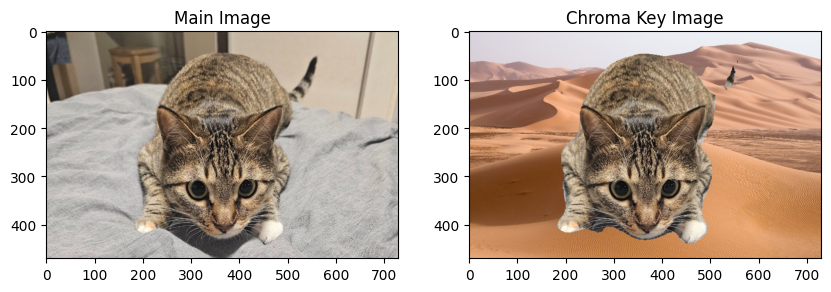

In [52]:
cat_img_path = "/content/cat.png"  # 고양이 이미지
background_img_path = "/content/desert.jpg"  # 사막 이미지

cat_img = cv2.imread(cat_img_path)
background_img = cv2.imread(background_img_path)

Chroma_Key(cat_img, background_img)

크로마키 문제점:  
- 꼬리 부분이 인식이 잘 되지 않았다.
- 머리 그림자 부분의 테두리가 불안정하다.

# 위에서 생성한 인물 모드 사진의 문제점 3가지

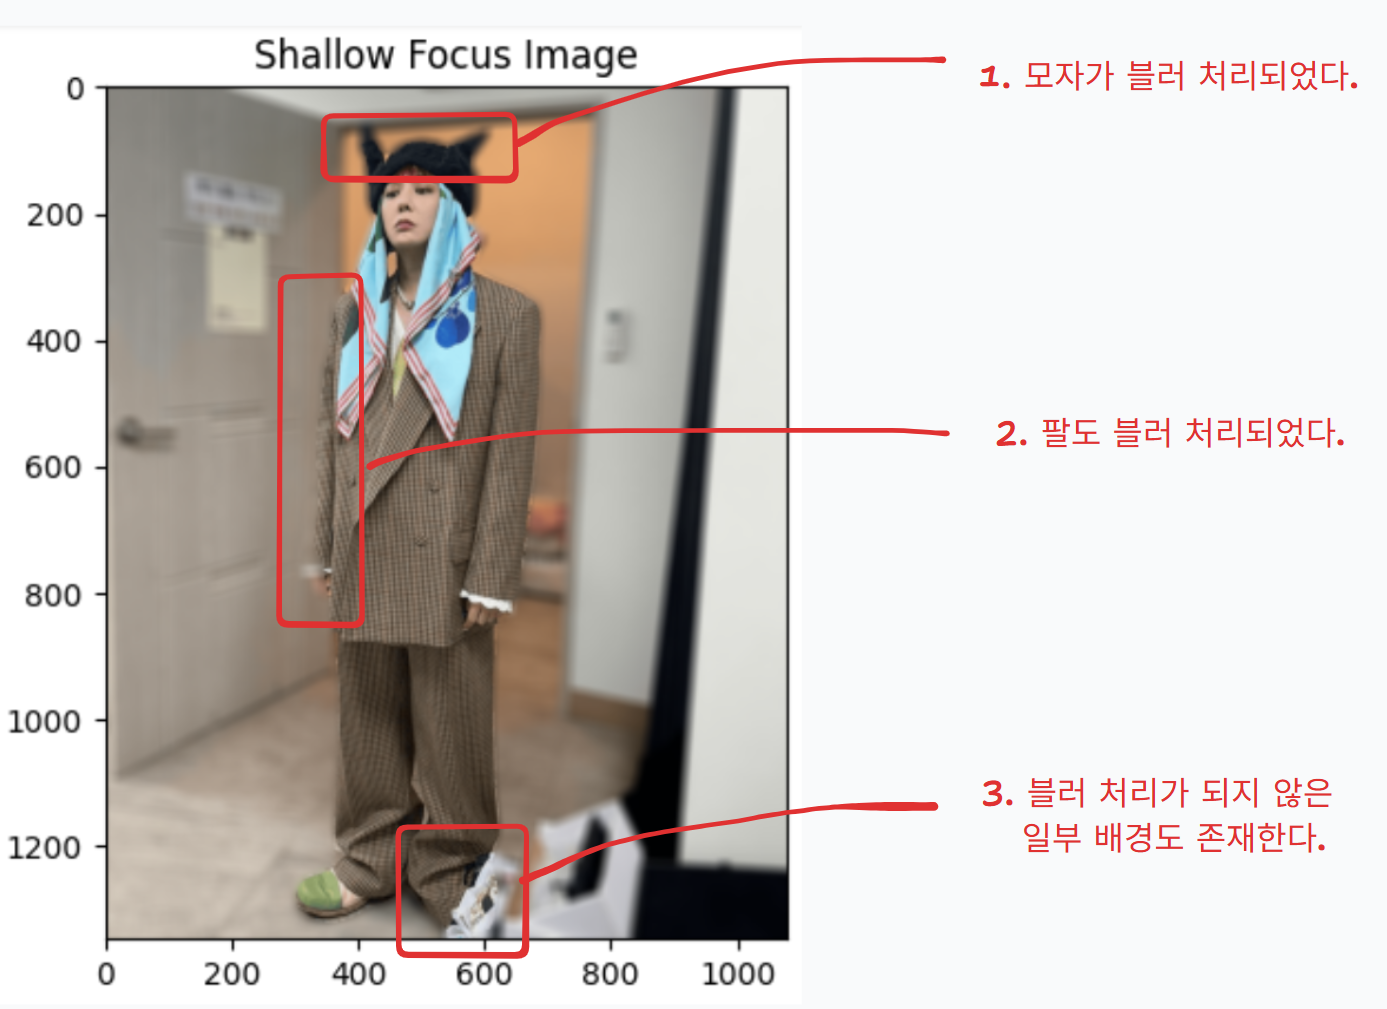

# **문제의 원인**
이 세 가지 문제점의 공통된 원인은 블러 처리 오류인데, 이는 블러 처리를 위해 선행한 세그멘테이션의 부정확함 때문이다.  
즉, deeplab3 모델이 생성한 시멘틱 세그멘테이션 마스크가 원인이라고 할 수 있다.  
<br>

# **솔루션**
깊이 추정 모델로 변경  
<br>
### **선택 이유**  
원래 아웃포커싱의 원리는 **"피사체가 무엇인지"** 가 아닌 **"피사체가 카메라로부터 얼마나 멀리 있는지"** 이므로 전자의 방식은 한계를 가진다.  
<br>
### **매커니즘:**  
1. 깊이 추정 모델 로드:  
기존 deeplab3 모델 대신, 이미지의 깊이를 추정하는 `MiDaS` 모델을 로드한다.
2. 깊이 맵(Depth Map) 생성:  
이미지의 픽셀별 깊이 정보를 담은 `depth_map`을 생성한다. (가까울수록 높은 값을 갖도록)  
3. 깊이 마스크(Depth Mask) 생성:  
    - `depth_map`에 `cv2.normalize`를 사용해 0~255 범위로 정규화한다.  
    - `cv2.threshold` 함수로 임계값을 정하고, 그 값보다 높은 값을 가지는 픽셀은 225, 낮은 값은 0을 할당한 `img_mask`를 생성한다.  
4. 이미지 합성:  
생성된 `img_mask`를 기반으로 기존 코드와 동일하게 배경 추출, 합성을 진행한다.  


---
# 프로젝트 과제 완료
---

### (추가) 솔루션을 적용한다면?

In [3]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 0. 기본 설정 ---
# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def shallow_focus_with_depth(img_orig, threshold_val=180, blur_level=(25, 25)):
    """
    단안 깊이 추정(Monocular Depth Estimation) 모델을 사용하여
    이미지에 얕은 초점(Shallow Focus) 효과를 적용하는 함수

    model: MiDaS (DPT_Large)

    Args:
        img_orig (np.ndarray): BGR 형식의 원본 OpenCV 이미지
        threshold_val (int): 깊이 임계값 (0~255).
                             값이 높을수록 '가깝다'고 판단하는 기준이 엄격해집니다.
                             (즉, 더 가까운 물체만 전경으로 선택됨)
        blur_level (tuple): 배경에 적용할 블러(blur) 커널 크기
    """

    print("--- 1. 모델 다운로드 및 전처리 ---")

    # 1-1. MiDaS 모델 및 변환(transform) 로드
    # 이 부분은 효율성을 위해 함수 외부에서 한 번만 로드하는 것이 좋으나,
    # 요청하신 함수화 구조를 따르기 위해 내부에 포함시켰습니다.
    try:
        model_type = "DPT_Large" # (DPT_Large, DPT_Hybrid, MiDaS_small)
        model = torch.hub.load("intel-isl/MiDaS", model_type)
        model.to(device).eval()

        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        transform = midas_transforms.dpt_transform if model_type == "DPT_Large" or model_type == "DPT_Hybrid" else midas_transforms.small_transform

    except Exception as e:
        print(f"모델 로드 중 오류 발생: {e}")
        print("인터넷 연결을 확인하거나 MiDaS 저장소를 확인하세요.")
        return

    # 1-2. 이미지 전처리
    # MiDaS는 RGB 입력을 기대하므로 BGR -> RGB 변환
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    input_batch = transform(img_rgb).to(device)


    print("--- 2. 깊이 맵(Depth Map) 추정 ---")
    with torch.no_grad():
        prediction = model(input_batch)

        # 2-1. 원본 이미지 크기로 깊이 맵 업샘플링(interpolate)
        depth_map = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(img_orig.shape[0], img_orig.shape[1]), # (Height, Width)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # 2-2. 텐서를 CPU의 numpy 배열로 변환
    depth_map_numpy = depth_map.cpu().numpy()


    print("--- 3. 깊이 마스크 생성 및 배경 흐리게 처리 ---")

    # 3-1. 깊이 맵 정규화 (0~255 값으로 변환)
    # MiDaS 출력: 값이 높을수록 가까움 (Inverse Depth)
    depth_map_normalized = cv2.normalize(depth_map_numpy, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # 3-2. 임계값 처리(Thresholding)로 전경 마스크 생성
    # threshold_val 값보다 '가까운(밝은)' 픽셀만 전경(흰색, 255)으로 선택
    _, img_mask = cv2.threshold(depth_map_normalized, threshold_val, 255, cv2.THRESH_BINARY_INV)

    # 3-3. 원본 이미지 배경 흐리게 처리
    img_orig_blur = cv2.blur(img_orig, blur_level)


    print("--- 4. 흐린 배경과 원본 영상 합성 ---")

    # 4-1. 마스크를 3채널(BGR)로 변환
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 4-2. np.where를 사용하여 마스크 기준으로 합성
    # 마스크가 255(흰색, 전경)인 곳은 원본(img_orig)을,
    # 마스크가 0(검은색, 배경)인 곳은 흐린 배경(img_orig_blur)을 선택
    result_img = np.where(img_mask_color == 255, img_orig, img_orig_blur)


    print("--- 5. 최종 이미지 출력 ---")

    # --- 5. 최종 이미지 출력 ---

    # Matplotlib은 RGB 순서를 기대하므로 BGR -> RGB 변환
    img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # 시각화를 위해 정규화된 맵을 반전 (인물이 밝게 보이도록)
    depth_map_inverted = cv2.bitwise_not(depth_map_normalized)
    depth_map_display = cv2.cvtColor(depth_map_inverted, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img_orig_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(depth_map_display)
    plt.title(f"Depth Map (Inverted, Threshold = {threshold_val})")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_img_rgb)
    plt.title("Shallow Focus (Fixed)")
    plt.axis('off')

    plt.show()

Using device: cuda


--- 1. 모델 다운로드 및 전처리 ---


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:13<00:00, 105MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


--- 2. 깊이 맵(Depth Map) 추정 ---
--- 3. 깊이 마스크 생성 및 배경 흐리게 처리 ---
--- 4. 흐린 배경과 원본 영상 합성 ---
--- 5. 최종 이미지 출력 ---


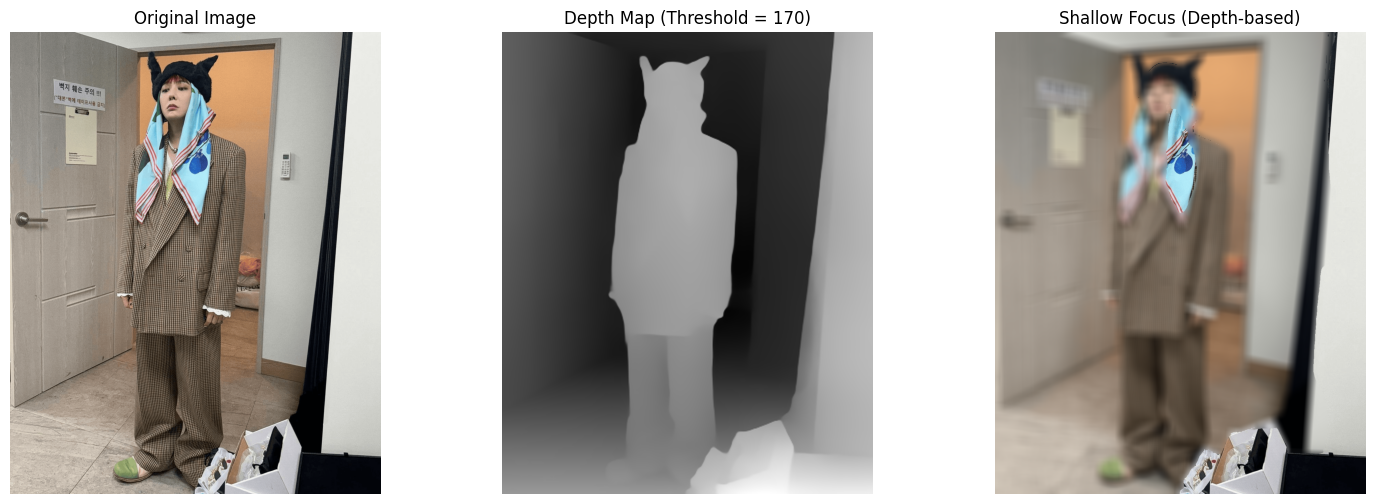

In [2]:
main_img = cv2.imread("/content/gd.png")

if main_img is None:
    print(f"이미지를 불러올 수 없습니다: {img_path}")
else:
    # threshold_val 값을 조절하여 전경/배경 범위를 변경해볼 수 있습니다.
    shallow_focus_with_depth(main_img, threshold_val=170, blur_level=(30, 30))